# Table of Contents

* [Setup Environment](#section1)
* [Functions](#section2)
* [1950-1959](#section3)
    * [Topic Modeling](#section_3_1)
        * [Check Coherence](#section_3_1_1)
        * [Save Final Model](#section_3_1_2)
    * [Explore Model](#section_3_2)
        * [Extracting Topics](#section_3_2_1)
        * [Visualizations](#section_3_2_2)
* [1960-1969](#section4)
    * [Topic Modeling](#section_4_1)
        * [Check Coherence](#section_4_1_1)
        * [Save Final Model](#section_4_1_2)
    * [Explore Model](#section_4_2)
        * [Extracting Topics](#section_4_2_1)
        * [Visualizations](#section_4_2_2)
* [1970-1979](#section5)
    * [Topic Modeling](#section_5_1)
        * [Check Coherence](#section_5_1_1)
        * [Save Final Model](#section_5_1_2)
    * [Explore Model](#section_5_2)
        * [Extracting Topics](#section_5_2_1)
        * [Visualizations](#section_5_2_2)
* [1980-1989](#section6)
    * [Topic Modeling](#section_6_1)
        * [Check Coherence](#section_6_1_1)
        * [Save Final Model](#section_6_1_2)
    * [Explore Model](#section_6_2)
        * [Extracting Topics](#section_6_2_1)
        * [Visualizations](#section_6_2_2)
* [1990-1999](#section7)
    * [Topic Modeling](#section_7_1)
        * [Check Coherence](#section_7_1_1)
        * [Save Final Model](#section_7_1_2)
    * [Explore Model](#section_7_2)
        * [Extracting Topics](#section_7_2_1)
        * [Visualizations](#section_7_2_2)
* [2000-2009](#section8)
    * [Topic Modeling](#section_8_1)
        * [Check Coherence](#section_8_1_1)
        * [Save Final Model](#section_8_1_2)
    * [Explore Model](#section_8_2)
        * [Extracting Topics](#section_8_2_1)
        * [Visualizations](#section_8_2_2)
* [2010-2019](#section9)
    * [Topic Modeling](#section_9_1)
        * [Check Coherence](#section_9_1_1)
        * [Save Final Model](#section_9_1_2)
    * [Explore Model](#section_9_2)
        * [Extracting Topics](#section_9_2_1)
        * [Visualizations](#section_9_2_2)

# Setup Environment <a class=anchor id=section1></a>

In [4]:
%%capture
# use ml.c5.2xlarge or ml.g4dn.xlarge instance
!apt-get update
!apt-get install --reinstall build-essential --yes

In [5]:
%%capture
!pip install bertopic
!pip install farm-haystack
!pip install spacy
!pip install gensim
!pip install sagemaker_pyspark
!python -m spacy download en_core_web_sm

In [6]:
%%capture
import re
import glob
import spacy
import gensim
import string
import pickle
import logging
import pyspark
import pynndescent
import numpy as np
import pandas as pd
import plotly.io as pio
import matplotlib.pyplot as plt
import gensim.corpora as corpora

from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from haystack.nodes import PreProcessor
from gensim.utils import simple_preprocess
from nltk.corpus import PlaintextCorpusReader
from haystack.utils import convert_files_to_docs
from sentence_transformers import SentenceTransformer
from gensim.models.coherencemodel import CoherenceModel

np.random.seed(0)
pio.renderers.default='iframe'
stop_words = stopwords.words('english')
common_words = ['from', 'subject', 're', 'edu', 'use', 'said', 'find', 'still', 'take', 'year', 'first', 'be', 'am', 
                'are', 'is', 'was', 'were', 'being', 'can', 'could', 'do', 'did', 'does', 'doing', 'have', 'had', 
                'has', 'having', 'may', 'might', 'must', 'shall', 'should', 'will', 'would', 'still', 'going', 'never', 
                'incb21', 'outst21', '000c8', 'sfas', 'rev11', 'inct', 'amer', 'thet', 'inds_inct', 'adrt', 'natl', 
                'benihana_natl', 'tofruzen', 'indst', 'finl', 'inc10', 'amer_commun', 'incn', 'said', 'like', 'sept', 
                'mon', 'tues', 'wed', 'thu', 'fri', 'sat', 'sun', 'east', 'meany', 'corp', 'intl', 'inds', 'pas', 'return', 
                'trela', 'foot', 'time', 'named', 'also']
stop_words.extend(common_words)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
pynndescent.rp_trees.FlatTree.__module__  = "pynndescent.rp_trees"
logging.getLogger("haystack.utils.preprocessing").setLevel(logging.ERROR)

In [7]:
%%capture
import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from transformers.pipelines import pipeline
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('wordnet')
nltk.download('omw-1.4')
token_pattern = re.compile(r"(?u)\b\w\w+\b")
sentence_model = SentenceTransformer("all-distilroberta-v1")
# sentence_model = SentenceTransformer("allenai/longformer-large-4096")
# sentence_model = SentenceTransformer("Peltarion/xlm-roberta-longformer-base-4096")
# sentence_model = SentenceTransformer("google/reformer-enwik8")

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [
            self.wnl.lemmatize(t)
            for t in word_tokenize(doc)
            if (len(t) > 3 and re.match("[a-z].*", t) and re.match(token_pattern, t)) or (t=='ai')
        ]

# Functions <a class=anchor id=section2></a>

In [8]:
# Remove copyright parts from articles
def remove_copyright_footer(sentence):
    sentence = sentence.lower()
    sentence = sentence.replace('reproduced with permission of the copyright owner.', '')
    sentence = sentence.replace('further reproduction prohibited without permission.', '')
    return sentence.replace('further reproduction is prohibited without permission.', '')

In [9]:
def pre_process(source):
    all_docs = convert_files_to_docs(dir_path=source)
    # Remove documents with less than 10 words
    selected_docs = [doc for doc in all_docs if len(doc.content.split()) >= 10]
    # Basic preprocessing
    preprocessor = PreProcessor(
        clean_empty_lines=True,
        clean_whitespace=True,
        clean_header_footer=True,
#     clean_header_footer=False,
#     split_by="word",
#     split_length=500,
#     split_respect_sentence_boundary=True,
        split_by=None
    )
    data = [item.content for item in preprocessor.process(selected_docs)]
    # Remove Links
    data = [re.sub(r'http\S+', '', sent) for sent in data]
    # Remove footer
    data = [remove_copyright_footer(sent) for sent in data]
    # Fix spaces
    data = [sent.strip() for sent in data]
    # Remove multiple space and new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
    # Remove special characters
    data = [re.sub(r'[^\x00-\x7f]',r'', sent) for sent in data]
    # # Remove some punctuations
    data = [item.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))) for item in data]
    # Remove multiple space and new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]
    # Remove distracting single quotes
    processed_docs = [re.sub("\'", "", sent) for sent in data]
    
    print(f"Number of input files: {len(all_docs)}\n"+
          f"Number of selected files: {len(selected_docs)}\n"+
          f"Number of output files: {len(processed_docs)}")
    return processed_docs

In [10]:
def training(docs, docs_embeddings, cluster_size=100):
    vectorizer_model= CountVectorizer(stop_words=stop_words, tokenizer=LemmaTokenizer())
    # Set the random state in the UMAP model to prevent stochastic behavior 
    umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
    hdbscan_model = HDBSCAN(min_cluster_size=cluster_size, metric='euclidean', prediction_data=True)
    topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True,  nr_topics="auto", 
                           vectorizer_model=vectorizer_model, umap_model=umap_model, hdbscan_model=hdbscan_model)
    topics, probs = topic_model.fit_transform(docs, docs_embeddings)
    
    ##### Calculate Coherence
    # Preprocess Documents
    documents = pd.DataFrame({"Document": docs,
                              "ID": range(len(docs)),
                              "Topic": topics})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

    # Extract vectorizer and analyzer from BERTopic
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Extract features for Topic Coherence evaluation
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, probs in topic_model.get_topic(topic)] 
                   for topic in range(len(set(topics))-1)]

    # Evaluate
    coherence_model = CoherenceModel(topics=topic_words, 
                                     texts=tokens, 
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='c_npmi')
    coherence_score = coherence_model.get_coherence()

    return topic_model, topics, probs, coherence_score

In [11]:
def draw_graph(start, limit, step, c_npmi, title):
    # Show graph
    x = range(start, limit, step)
    plt.plot(x, c_npmi)
    plt.title(title)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Coherence score")
    plt.legend(("c_npmi"), loc='best')
    plt.show()
    """
    # Print the coherence scores
    for i in range(0,len(c_npmi)):
        if str(c_npmi[i]) == 'nan':
            c_npmi[i]=float('-inf')
    """
    maximum = max(c_npmi)
    indices = [i for i, v in enumerate(c_npmi) if v == maximum]
    print("A maximum {} score of {} was achieved at K={}".format("c_npmi", maximum, indices[0]+1))
    # Return the index
    return indices[0]

In [10]:
!rm -r BERT/
!mkdir BERT

# 1950-1959 <a class=anchor id=section3></a>

## Topic Modeling <a class=anchor id=section_3_1></a>

In [11]:
!mkdir BERT/1950-1959/

In [12]:
# parameters
source = 'CLEANSED/1950-1959'
output = 'BERT/'+source.split("/")[1]+"/"
start, limit, step = 10, 100, 10
topic_models = []
coherences = []
topics = []
probs = []

In [13]:
# Create embeddings
docs = pre_process(source)
embeddings = sentence_model.encode(docs, show_progress_bar=True)


Number of input files: 1051
Number of selected files: 1051
Number of output files: 1051


In [14]:
# Create topic model
for i in range(start, limit, step):
    topic_model, topic, prob, coherence = training(docs, embeddings, i)
    topic_models.append(topic_model)
    topics.append(topic)
    probs.append(prob)
    coherences.append(coherence)

### Check Coherence <a class=anchor id=section_3_1_1></a>

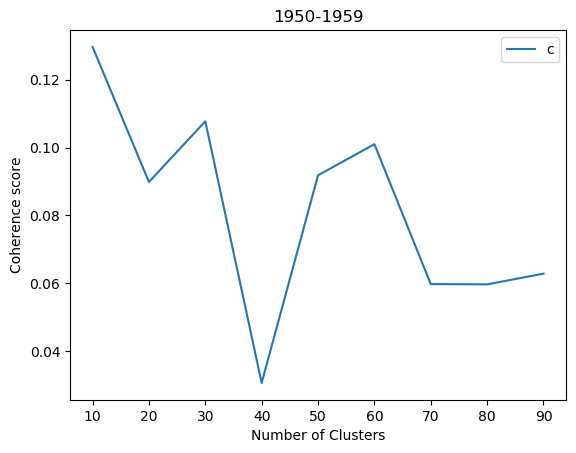

A maximum c_npmi score of 0.12963359257520415 was achieved at K=1


In [15]:
model_index = draw_graph(start, limit, step, coherences, source.split("/")[1])

> Hence, we select the model with the highest coherence value.

### Save Final Model <a class=anchor id=section_3_1_2></a>

In [16]:
topic_model, topic, prob, coherence = topic_models[model_index], topics[model_index], probs[model_index], coherences[model_index]
hierarchical_topics = topic_model.hierarchical_topics(docs, topic)

100%|██████████| 14/14 [00:00<00:00, 178.23it/s]


In [17]:
topic_model.save(output+"bert")
with open(output+'hierarchical_topics.pkl', 'wb') as f:
    pickle.dump(hierarchical_topics, f)
with open(output+'docs.pkl', 'wb') as f:
    pickle.dump(docs, f)
with open(output+'embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

## Explore Model <a class=anchor id=section_3_2></a>

In [18]:
topic_model = BERTopic.load(output+"bert")
with open(output+'hierarchical_topics.pkl', 'rb') as f:
    hierarchical_topics = pickle.load(f)
with open(output+'docs.pkl', 'rb') as f:
    docs = pickle.load(f)
with open(output+'embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)

### Extracting Topics <a class=anchor id=section_3_2_1></a>

After fitting our model, we can start by looking at the results. Typically, we look at the most frequent topics first as they best represent the collection of documents. 

In [19]:
freq = topic_model.get_topic_info()
freq.head(5)

,Topic,Count,Name
0,-1,270,-1_automation_company_machine_industry
1,0,169,0_union_labor_state_worker
2,1,161,1_company_share_stock_cent
3,2,76,2_soviet_communist_country_state
4,3,71,3_ship_cargo_union_port


> -1 refers to all outliers and should typically be ignored.

Next, let's take a look at a frequent topic that were generated:

In [20]:
# Select the most frequent topic
topic_model.get_topic(0)

[('union', 0.024247171078836616),
 ('labor', 0.022546251306160014),
 ('state', 0.019066829665627807),
 ('worker', 0.016767940290124083),
 ('president', 0.01615227666126577),
 ('economic', 0.01430784391883915),
 ('wage', 0.013487338824247458),
 ('program', 0.013432356728626828),
 ('work', 0.01295833556056691),
 ('industry', 0.012926618398087713)]

**NOTE**: BERTopic is stochastic which means that the topics might differ across runs. This is mostly due to the stocastisch nature of UMAP.

### Visualizations <a class=anchor id=section_3_2_2></a>

In [21]:
topic_model.visualize_topics()

In [22]:
topic_model.visualize_documents(docs, reduced_embeddings=embeddings)

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [23]:
topic_model.visualize_barchart(top_n_topics=6)

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we create clusters and visualize how they relate to one another.

In [24]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, top_n_topics=50)

Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [25]:
topic_model.visualize_heatmap(width=1000, height=1000)

Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation.

To visualize this effect, we can plot the c-TF-IDF scores for each topic by the term rank of each word. In other words, the position of the words (term rank), where the words with the highest c-TF-IDF score will have a rank of 1, will be put on the x-axis. Whereas the y-axis will be populated by the c-TF-IDF scores. The result is a visualization that shows you the decline of c-TF-IDF score when adding words to the topic representation. It allows you, using the elbow method, to select the best number of words in a topic.

In [26]:
topic_model.visualize_term_rank()

# 1960-1969 <a class=anchor id=section4></a>

## Topic Modeling <a class=anchor id=section_4_1></a>

In [27]:
!mkdir BERT/1960-1969/

In [28]:
# parameters
source = 'CLEANSED/1960-1969'
output = 'BERT/'+source.split("/")[1]+"/"
start, limit, step = 10, 100, 10
topic_models = []
coherences = []
topics = []
probs = []

In [29]:
# Create embeddings
docs = pre_process(source)
embeddings = sentence_model.encode(docs, show_progress_bar=True)


Number of input files: 2900
Number of selected files: 2900
Number of output files: 2900


In [30]:
# Create topic model
for i in range(start, limit, step):
    topic_model, topic, prob, coherence = training(docs, embeddings, i)
    topic_models.append(topic_model)
    topics.append(topic)
    probs.append(prob)
    coherences.append(coherence)

### Check Coherence <a class=anchor id=section_4_1_1></a>

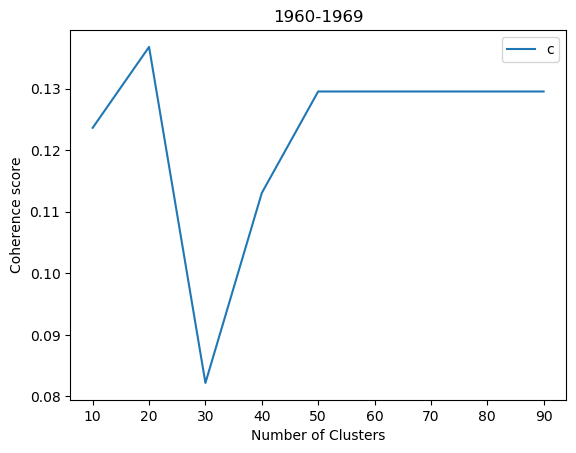

A maximum c_npmi score of 0.13677486458545757 was achieved at K=2


In [31]:
model_index = draw_graph(start, limit, step, coherences, source.split("/")[1])

> Hence, we select the model with the highest coherence value.

### Save Final Model <a class=anchor id=section_4_1_2></a>

In [32]:
topic_model, topic, prob, coherence = topic_models[model_index], topics[model_index], probs[model_index], coherences[model_index]
hierarchical_topics = topic_model.hierarchical_topics(docs, topic)

100%|██████████| 20/20 [00:00<00:00, 164.22it/s]


In [33]:
topic_model.save(output+"bert")
with open(output+'hierarchical_topics.pkl', 'wb') as f:
    pickle.dump(hierarchical_topics, f)
with open(output+'docs.pkl', 'wb') as f:
    pickle.dump(docs, f)
with open(output+'embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

## Explore Model <a class=anchor id=section_4_2></a>

In [34]:
topic_model = BERTopic.load(output+"bert")
with open(output+'hierarchical_topics.pkl', 'rb') as f:
    hierarchical_topics = pickle.load(f)
with open(output+'docs.pkl', 'rb') as f:
    docs = pickle.load(f)
with open(output+'embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)

### Extracting Topics <a class=anchor id=section_4_2_1></a>

After fitting our model, we can start by looking at the results. Typically, we look at the most frequent topics first as they best represent the collection of documents. 

In [35]:
freq = topic_model.get_topic_info()
freq.head(5)

,Topic,Count,Name
0,-1,935,-1_state_president_cent_labor
1,0,436,0_labor_negro_union_worker
2,1,348,1_stock_company_share_exchange
3,2,315,2_ship_union_maritime_marine
4,3,213,3_newspaper_publisher_union_guild


> -1 refers to all outliers and should typically be ignored.

Next, let's take a look at a frequent topic that were generated:

In [36]:
# Select the most frequent topic
topic_model.get_topic(0)

[('labor', 0.02383029890076494),
 ('negro', 0.0179344420273302),
 ('union', 0.017132249615642775),
 ('worker', 0.016167851839401115),
 ('job', 0.015935138147212587),
 ('president', 0.015921124756888814),
 ('unemployment', 0.015796079366135002),
 ('automation', 0.013288270332953933),
 ('economic', 0.01322934068469094),
 ('program', 0.013021693223727836)]

**NOTE**: BERTopic is stochastic which means that the topics might differ across runs. This is mostly due to the stocastisch nature of UMAP.

### Visualizations <a class=anchor id=section_4_2_2></a>

In [37]:
topic_model.visualize_topics()

In [38]:
topic_model.visualize_documents(docs, reduced_embeddings=embeddings)

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [39]:
topic_model.visualize_barchart(top_n_topics=6)

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we create clusters and visualize how they relate to one another.

In [40]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, top_n_topics=50)

Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [41]:
topic_model.visualize_heatmap(width=1000, height=1000)

Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation.

To visualize this effect, we can plot the c-TF-IDF scores for each topic by the term rank of each word. In other words, the position of the words (term rank), where the words with the highest c-TF-IDF score will have a rank of 1, will be put on the x-axis. Whereas the y-axis will be populated by the c-TF-IDF scores. The result is a visualization that shows you the decline of c-TF-IDF score when adding words to the topic representation. It allows you, using the elbow method, to select the best number of words in a topic.

In [42]:
topic_model.visualize_term_rank()

# 1970-1979 <a class=anchor id=section5></a>

## Topic Modeling <a class=anchor id=section_5_1></a>

In [2]:
!mkdir BERT/1970-1979/

In [2]:
# parameters
source = 'CLEANSED/1970-1979'
output = 'BERT/'+source.split("/")[1]+"/"
start, limit, step = 10, 100, 10
topic_models = []
coherences = []
topics = []
probs = []

In [ ]:
# Create embeddings
docs = pre_process(source)
embeddings = sentence_model.encode(docs, show_progress_bar=True)

In [ ]:
# Create topic model
for i in range(start, limit, step):
    topic_model, topic, prob, coherence = training(docs, embeddings, i)
    topic_models.append(topic_model)
    topics.append(topic)
    probs.append(prob)
    coherences.append(coherence)

### Check Coherence <a class=anchor id=section_5_1_1></a>

In [13]:
with open('topic_models.pkl', 'rb') as f:
    topic_models = pickle.load(f)
with open('topics.pkl', 'rb') as f:
    topics = pickle.load(f)
with open('probs.pkl', 'rb') as f:
    probs = pickle.load(f)
with open('coherences.pkl', 'rb') as f:
    coherences = pickle.load(f)

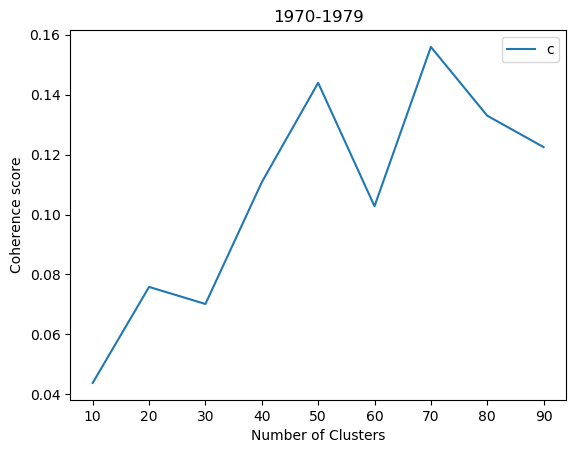

A maximum c_npmi score of 0.15589417461219793 was achieved at K=7


In [14]:
model_index = draw_graph(start, limit, step, coherences, source.split("/")[1])

> Hence, we select the model with the highest coherence value.

### Save Final Model <a class=anchor id=section_5_1_2></a>

In [15]:
topic_model, topic, prob, coherence = topic_models[model_index], topics[model_index], probs[model_index], coherences[model_index]
hierarchical_topics = topic_model.hierarchical_topics(docs, topic)

100%|██████████| 3/3 [00:00<00:00, 126.07it/s]


In [16]:
topic_model.save(output+"bert")
with open(output+'hierarchical_topics.pkl', 'wb') as f:
    pickle.dump(hierarchical_topics, f)
with open(output+'docs.pkl', 'wb') as f:
    pickle.dump(docs, f)
with open(output+'embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

## Explore Model <a class=anchor id=section_5_2></a>

In [17]:
topic_model = BERTopic.load(output+"bert")
with open(output+'hierarchical_topics.pkl', 'rb') as f:
    hierarchical_topics = pickle.load(f)
with open(output+'docs.pkl', 'rb') as f:
    docs = pickle.load(f)
with open(output+'embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)

### Extracting Topics <a class=anchor id=section_5_2_1></a>

After fitting our model, we can start by looking at the results. Typically, we look at the most frequent topics first as they best represent the collection of documents. 

In [18]:
freq = topic_model.get_topic_info()
freq.head(5)

,Topic,Count,Name
0,-1,2715,-1_income_earns_sale_union
1,0,516,0_union_work_state_labor
2,1,342,1_exchange_stock_company_market
3,2,117,2_hunter_horse_farm_green
4,3,84,3_theater_directed_closed_today


> -1 refers to all outliers and should typically be ignored.

Next, let's take a look at a frequent topic that were generated:

In [19]:
# Select the most frequent topic
topic_model.get_topic(0)

[('union', 0.020310838554009645),
 ('work', 0.015066976702028717),
 ('state', 0.014343786514570035),
 ('labor', 0.014125456846154216),
 ('american', 0.01406877056945443),
 ('worker', 0.014042256626102312),
 ('people', 0.013628599913706253),
 ('york', 0.013379749688136678),
 ('city', 0.013348150294899514),
 ('school', 0.011982098198218818)]

**NOTE**: BERTopic is stochastic which means that the topics might differ across runs. This is mostly due to the stocastisch nature of UMAP.

### Visualizations <a class=anchor id=section_5_2_2></a>

In [20]:
topic_model.visualize_topics()

In [21]:
topic_model.visualize_documents(docs, reduced_embeddings=embeddings)

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [22]:
topic_model.visualize_barchart(top_n_topics=6)

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we create clusters and visualize how they relate to one another.

In [23]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, top_n_topics=50)

Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [24]:
topic_model.visualize_heatmap(width=1000, height=1000)

Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation.

To visualize this effect, we can plot the c-TF-IDF scores for each topic by the term rank of each word. In other words, the position of the words (term rank), where the words with the highest c-TF-IDF score will have a rank of 1, will be put on the x-axis. Whereas the y-axis will be populated by the c-TF-IDF scores. The result is a visualization that shows you the decline of c-TF-IDF score when adding words to the topic representation. It allows you, using the elbow method, to select the best number of words in a topic.

In [25]:
topic_model.visualize_term_rank()

# 1980-1989 <a class=anchor id=section6></a>

## Topic Modeling <a class=anchor id=section_6_1></a>

In [21]:
!mkdir BERT/1980-1989/

In [22]:
# parameters
source = 'CLEANSED/1980-1989'
output = 'BERT/'+source.split("/")[1]+"/"
start, limit, step = 10, 100, 10
topic_models = []
coherences = []
topics = []
probs = []

In [23]:
# Create embeddings
docs = pre_process(source)
embeddings = sentence_model.encode(docs, show_progress_bar=True)


Number of input files: 1771
Number of selected files: 1753
Number of output files: 1753


In [24]:
# Create topic model
for i in range(start, limit, step):
    topic_model, topic, prob, coherence = training(docs, embeddings, i)
    topic_models.append(topic_model)
    topics.append(topic)
    probs.append(prob)
    coherences.append(coherence)

### Check Coherence <a class=anchor id=section_6_1_1></a>

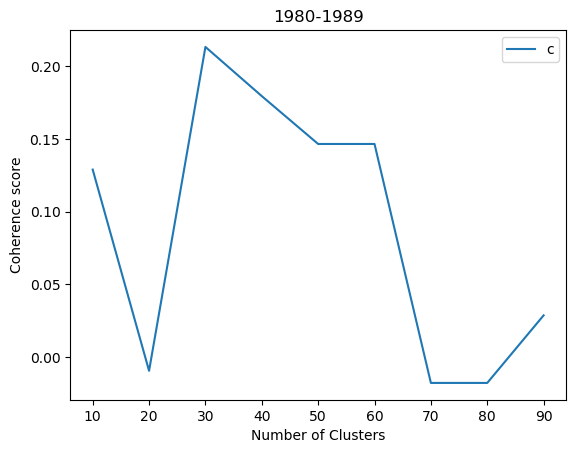

A maximum c_npmi score of 0.21326237161286826 was achieved at K=3


In [25]:
model_index = draw_graph(start, limit, step, coherences, source.split("/")[1])

> Hence, we select the model with the highest coherence value.

### Save Final Model <a class=anchor id=section_6_1_2></a>

In [26]:
topic_model, topic, prob, coherence = topic_models[model_index], topics[model_index], probs[model_index], coherences[model_index]
hierarchical_topics = topic_model.hierarchical_topics(docs, topic)

100%|██████████| 4/4 [00:00<00:00, 121.14it/s]


In [27]:
topic_model.save(output+"bert")
with open(output+'hierarchical_topics.pkl', 'wb') as f:
    pickle.dump(hierarchical_topics, f)
with open(output+'docs.pkl', 'wb') as f:
    pickle.dump(docs, f)
with open(output+'embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

## Explore Model <a class=anchor id=section_6_2></a>

In [28]:
topic_model = BERTopic.load(output+"bert")
with open(output+'hierarchical_topics.pkl', 'rb') as f:
    hierarchical_topics = pickle.load(f)
with open(output+'docs.pkl', 'rb') as f:
    docs = pickle.load(f)
with open(output+'embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)

### Extracting Topics <a class=anchor id=section_6_2_1></a>

After fitting our model, we can start by looking at the results. Typically, we look at the most frequent topics first as they best represent the collection of documents. 

In [29]:
freq = topic_model.get_topic_info()
freq.head(5)

,Topic,Count,Name
0,-1,27,-1_university_father_graduated_york
1,0,1464,0_company_computer_percent_system
2,1,83,1_earns_report_share_automation
3,2,76,2_president_vice_named_chief
4,3,63,3_airline_pilot_plane_flight


> -1 refers to all outliers and should typically be ignored.

Next, let's take a look at a frequent topic that were generated:

In [30]:
# Select the most frequent topic
topic_model.get_topic(0)

[('company', 0.03298654829452128),
 ('computer', 0.020793691449488446),
 ('percent', 0.01830429892526068),
 ('system', 0.017739137930844678),
 ('million', 0.017396717656660978),
 ('industry', 0.016947126375191773),
 ('worker', 0.01520598727541383),
 ('market', 0.015152566663903978),
 ('business', 0.01485242686662123),
 ('state', 0.014031438711881348)]

**NOTE**: BERTopic is stochastic which means that the topics might differ across runs. This is mostly due to the stocastisch nature of UMAP.

### Visualizations <a class=anchor id=section_6_2_2></a>

In [31]:
topic_model.visualize_topics()

In [32]:
topic_model.visualize_documents(docs, reduced_embeddings=embeddings)

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [33]:
topic_model.visualize_barchart(top_n_topics=6)

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we create clusters and visualize how they relate to one another.

In [34]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, top_n_topics=50)

Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [35]:
topic_model.visualize_heatmap(width=1000, height=1000)

Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation.

To visualize this effect, we can plot the c-TF-IDF scores for each topic by the term rank of each word. In other words, the position of the words (term rank), where the words with the highest c-TF-IDF score will have a rank of 1, will be put on the x-axis. Whereas the y-axis will be populated by the c-TF-IDF scores. The result is a visualization that shows you the decline of c-TF-IDF score when adding words to the topic representation. It allows you, using the elbow method, to select the best number of words in a topic.

In [36]:
topic_model.visualize_term_rank()

# 1990-1999 <a class=anchor id=section7></a>

## Topic Modeling <a class=anchor id=section_7_1></a>

In [37]:
!mkdir BERT/1990-1999/

In [38]:
# parameters
source = 'CLEANSED/1990-1999'
output = 'BERT/'+source.split("/")[1]+"/"
start, limit, step = 10, 100, 10
topic_models = []
coherences = []
topics = []
probs = []

In [39]:
# Create embeddings
docs = pre_process(source)
embeddings = sentence_model.encode(docs, show_progress_bar=True)


Number of input files: 1520
Number of selected files: 1368
Number of output files: 1368


In [40]:
# Create topic model
for i in range(start, limit, step):
    topic_model, topic, prob, coherence = training(docs, embeddings, i)
    topic_models.append(topic_model)
    topics.append(topic)
    probs.append(prob)
    coherences.append(coherence)

In [41]:
topic_ids = topic_model.get_topic_info().Topic.unique().tolist()
[topic_model.get_topic(topic) for topic in topic_ids]

[[('system', 0.027858453421040482),
  ('company', 0.027216988288156833),
  ('computer', 0.019006482046528342),
  ('million', 0.018463069593945804),
  ('state', 0.01667056566797587),
  ('york', 0.016006913894626194),
  ('people', 0.015536654068601927),
  ('percent', 0.014993453472893227),
  ('also', 0.01380122872225342),
  ('last', 0.013561745287805314)],
 [('company', 0.054376122367713255),
  ('computer', 0.040278268628354985),
  ('million', 0.03441024049877224),
  ('system', 0.031545039972552355),
  ('technology', 0.02812649141142887),
  ('software', 0.026107085828138015),
  ('rockwell', 0.02484798526455022),
  ('share', 0.024735245303134146),
  ('business', 0.024423902472538506),
  ('automation', 0.024261321248426712)],
 [('worker', 0.04563578646178649),
  ('company', 0.03642430219715559),
  ('job', 0.03173868506323065),
  ('percent', 0.031679840982141855),
  ('work', 0.027969697305316104),
  ('labor', 0.025849141589204934),
  ('people', 0.02472137709661615),
  ('hour', 0.02316295281

### Check Coherence <a class=anchor id=section_7_1_1></a>

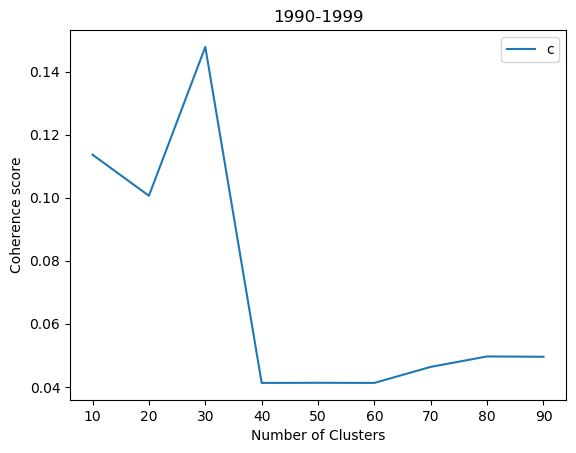

A maximum c_npmi score of 0.1478399923699352 was achieved at K=3


In [42]:
model_index = draw_graph(start, limit, step, coherences, source.split("/")[1])

> Hence, we select the model with the highest coherence value.

### Save Final Model <a class=anchor id=section_7_1_2></a>

In [43]:
topic_model, topic, prob, coherence = topic_models[model_index], topics[model_index], probs[model_index], coherences[model_index]
hierarchical_topics = topic_model.hierarchical_topics(docs, topic)

100%|██████████| 4/4 [00:00<00:00, 143.27it/s]


In [44]:
topic_model.save(output+"bert")
with open(output+'hierarchical_topics.pkl', 'wb') as f:
    pickle.dump(hierarchical_topics, f)
with open(output+'docs.pkl', 'wb') as f:
    pickle.dump(docs, f)
with open(output+'embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

## Explore Model <a class=anchor id=section_7_2></a>

In [45]:
topic_model = BERTopic.load(output+"bert")
with open(output+'hierarchical_topics.pkl', 'rb') as f:
    hierarchical_topics = pickle.load(f)
with open(output+'docs.pkl', 'rb') as f:
    docs = pickle.load(f)
with open(output+'embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)

### Extracting Topics <a class=anchor id=section_7_2_1></a>

After fitting our model, we can start by looking at the results. Typically, we look at the most frequent topics first as they best represent the collection of documents. 

In [46]:
freq = topic_model.get_topic_info()
freq.head(5)

,Topic,Count,Name
0,-1,30,-1_tech_pilot_short_captain
1,0,1156,0_company_computer_million_percent
2,1,68,1_system_traffic_controller_airline
3,2,44,2_train_subway_authority_transit
4,3,37,3_toll_bridge_jersey_authority


> -1 refers to all outliers and should typically be ignored.

Next, let's take a look at a frequent topic that were generated:

In [47]:
# Select the most frequent topic
topic_model.get_topic(0)

[('company', 0.028366858768707728),
 ('computer', 0.01747047457771637),
 ('million', 0.017289272576944494),
 ('percent', 0.01624491736880876),
 ('system', 0.01604365044362283),
 ('people', 0.01449705888469802),
 ('business', 0.014068091605122336),
 ('work', 0.013357980087419782),
 ('state', 0.013331873049889179),
 ('worker', 0.013053652395600763)]

**NOTE**: BERTopic is stochastic which means that the topics might differ across runs. This is mostly due to the stocastisch nature of UMAP.

### Visualizations <a class=anchor id=section_7_2_2></a>

In [48]:
topic_model.visualize_topics()

In [49]:
topic_model.visualize_documents(docs, reduced_embeddings=embeddings)

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [50]:
topic_model.visualize_barchart(top_n_topics=6)

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we create clusters and visualize how they relate to one another.

In [51]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, top_n_topics=50)

Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [52]:
topic_model.visualize_heatmap(width=1000, height=1000)

Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation.

To visualize this effect, we can plot the c-TF-IDF scores for each topic by the term rank of each word. In other words, the position of the words (term rank), where the words with the highest c-TF-IDF score will have a rank of 1, will be put on the x-axis. Whereas the y-axis will be populated by the c-TF-IDF scores. The result is a visualization that shows you the decline of c-TF-IDF score when adding words to the topic representation. It allows you, using the elbow method, to select the best number of words in a topic.

In [53]:
topic_model.visualize_term_rank()

# 2000-2009 <a class=anchor id=section8></a>

## Topic Modeling <a class=anchor id=section_8_1></a>

In [22]:
!mkdir BERT/2000-2009/

In [23]:
# parameters
source = 'CLEANSED/2000-2009'
output = 'BERT/'+source.split("/")[1]+"/"
start, limit, step = 10, 100, 10
topic_models = []
coherences = []
topics = []
probs = []

In [24]:
# Create embeddings
docs = pre_process(source)
embeddings = sentence_model.encode(docs, show_progress_bar=True)


Number of input files: 4020
Number of selected files: 4018
Number of output files: 4018


In [25]:
# Create topic model
for i in range(start, limit, step):
    topic_model, topic, prob, coherence = training(docs, embeddings, i)
    topic_models.append(topic_model)
    topics.append(topic)
    probs.append(prob)
    coherences.append(coherence)

### Check Coherence <a class=anchor id=section_8_1_1></a>

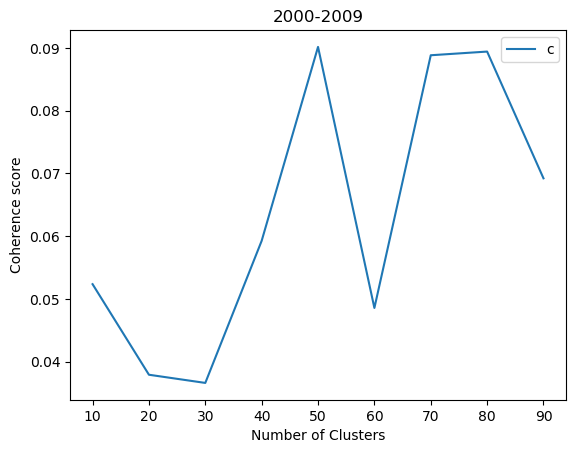

A maximum c_npmi score of 0.09014090311623617 was achieved at K=5


In [26]:
model_index = draw_graph(start, limit, step, coherences, source.split("/")[1])

> Hence, we select the model with the highest coherence value.

### Save Final Model <a class=anchor id=section_8_1_2></a>

In [27]:
topic_model, topic, prob, coherence = topic_models[model_index], topics[model_index], probs[model_index], coherences[model_index]
hierarchical_topics = topic_model.hierarchical_topics(docs, topic)

100%|██████████| 18/18 [00:00<00:00, 172.60it/s]


In [28]:
topic_model.save(output+"bert")
with open(output+'hierarchical_topics.pkl', 'wb') as f:
    pickle.dump(hierarchical_topics, f)
with open(output+'docs.pkl', 'wb') as f:
    pickle.dump(docs, f)
with open(output+'embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

## Explore Model <a class=anchor id=section_8_2></a>

In [29]:
topic_model = BERTopic.load(output+"bert")
with open(output+'hierarchical_topics.pkl', 'rb') as f:
    hierarchical_topics = pickle.load(f)
with open(output+'docs.pkl', 'rb') as f:
    docs = pickle.load(f)
with open(output+'embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)

### Extracting Topics <a class=anchor id=section_8_2_1></a>

After fitting our model, we can start by looking at the results. Typically, we look at the most frequent topics first as they best represent the collection of documents. 

In [30]:
freq = topic_model.get_topic_info()
freq.head(5)

,Topic,Count,Name
0,-1,1168,-1_company_system_people_state
1,0,792,0_company_software_system_home
2,1,424,1_airline_system_state_ticket
3,2,210,2_job_economy_work_economic
4,3,174,3_exchange_trading_stock_trade


> -1 refers to all outliers and should typically be ignored.

Next, let's take a look at a frequent topic that were generated:

In [31]:
# Select the most frequent topic
topic_model.get_topic(0)

[('company', 0.023566253313761578),
 ('software', 0.02172701407852252),
 ('system', 0.017673047790664823),
 ('home', 0.017238330769632007),
 ('computer', 0.01706902007239961),
 ('microsoft', 0.015995252196930602),
 ('service', 0.01522540689608559),
 ('technology', 0.014839362808144215),
 ('customer', 0.013477550818427797),
 ('percent', 0.012589185453848531)]

**NOTE**: BERTopic is stochastic which means that the topics might differ across runs. This is mostly due to the stocastisch nature of UMAP.

### Visualizations <a class=anchor id=section_8_2_2></a>

In [32]:
topic_model.visualize_topics()

In [33]:
topic_model.visualize_documents(docs, reduced_embeddings=embeddings)

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [34]:
topic_model.visualize_barchart(top_n_topics=6)

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we create clusters and visualize how they relate to one another.

In [35]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, top_n_topics=50)

Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [36]:
topic_model.visualize_heatmap(width=1000, height=1000)

Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation.

To visualize this effect, we can plot the c-TF-IDF scores for each topic by the term rank of each word. In other words, the position of the words (term rank), where the words with the highest c-TF-IDF score will have a rank of 1, will be put on the x-axis. Whereas the y-axis will be populated by the c-TF-IDF scores. The result is a visualization that shows you the decline of c-TF-IDF score when adding words to the topic representation. It allows you, using the elbow method, to select the best number of words in a topic.

In [37]:
topic_model.visualize_term_rank()

# 2010-2019 <a class=anchor id=section9></a>

## Topic Modeling <a class=anchor id=section_9_1></a>

In [65]:
!mkdir BERT/2010-2019/

In [66]:
# parameters
source = 'CLEANSED/2010-2019'
output = 'BERT/'+source.split("/")[1]+"/"
start, limit, step = 10, 100, 10
topic_models = []
coherences = []
topics = []
probs = []

In [67]:
# Create embeddings
docs = pre_process(source)
embeddings = sentence_model.encode(docs, show_progress_bar=True)


Number of input files: 2852
Number of selected files: 2852
Number of output files: 2852


In [68]:
# Create topic model
for i in range(start, limit, step):
    topic_model, topic, prob, coherence = training(docs, embeddings, i)
    topic_models.append(topic_model)
    topics.append(topic)
    probs.append(prob)
    coherences.append(coherence)

### Check Coherence <a class=anchor id=section_9_1_1></a>

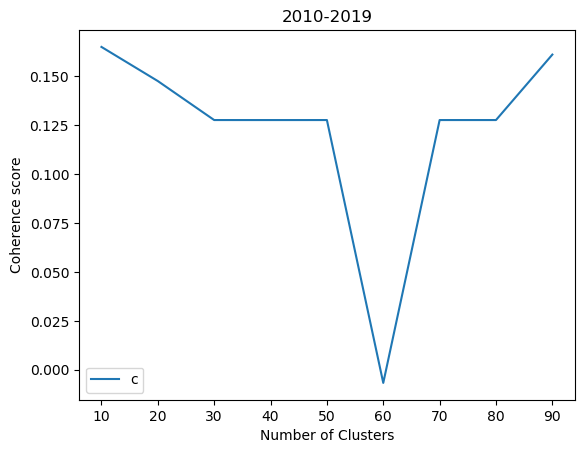

A maximum c_npmi score of 0.165035945988405 was achieved at K=1


In [69]:
model_index = draw_graph(start, limit, step, coherences, source.split("/")[1])

> Hence, we select the model with the highest coherence value.

### Save Final Model <a class=anchor id=section_9_1_2></a>

In [70]:
topic_model, topic, prob, coherence = topic_models[model_index], topics[model_index], probs[model_index], coherences[model_index]
hierarchical_topics = topic_model.hierarchical_topics(docs, topic)

100%|██████████| 7/7 [00:00<00:00, 130.72it/s]


In [71]:
topic_model.save(output+"bert")
with open(output+'hierarchical_topics.pkl', 'wb') as f:
    pickle.dump(hierarchical_topics, f)
with open(output+'docs.pkl', 'wb') as f:
    pickle.dump(docs, f)
with open(output+'embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

## Explore Model <a class=anchor id=section_9_2></a>

In [72]:
topic_model = BERTopic.load(output+"bert")
with open(output+'hierarchical_topics.pkl', 'rb') as f:
    hierarchical_topics = pickle.load(f)
with open(output+'docs.pkl', 'rb') as f:
    docs = pickle.load(f)
with open(output+'embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)

### Extracting Topics <a class=anchor id=section_9_2_1></a>

After fitting our model, we can start by looking at the results. Typically, we look at the most frequent topics first as they best represent the collection of documents. 

In [73]:
freq = topic_model.get_topic_info()
freq.head(5)

,Topic,Count,Name
0,-1,559,-1_company_people_worker_percent
1,0,2066,0_company_people_state_technology
2,1,78,1_pilot_boeing_plane_flight
3,2,61,2_bride_graduated_father_groom
4,3,24,3_wine_cheese_barrel_cottage


> -1 refers to all outliers and should typically be ignored.

Next, let's take a look at a frequent topic that were generated:

In [74]:
# Select the most frequent topic
topic_model.get_topic(0)

[('company', 0.019941462290457988),
 ('people', 0.014238361016159749),
 ('state', 0.01291470545224444),
 ('technology', 0.012398465891951293),
 ('also', 0.012324388141455892),
 ('work', 0.012280731086186268),
 ('worker', 0.011282228661776214),
 ('many', 0.011125289336672759),
 ('make', 0.01078733401824957),
 ('percent', 0.01070239923008508)]

**NOTE**: BERTopic is stochastic which means that the topics might differ across runs. This is mostly due to the stocastisch nature of UMAP.

### Visualizations <a class=anchor id=section_9_2_2></a>

In [75]:
topic_model.visualize_topics()

In [76]:
topic_model.visualize_documents(docs, reduced_embeddings=embeddings)

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [77]:
topic_model.visualize_barchart(top_n_topics=6)

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we create clusters and visualize how they relate to one another.

In [78]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, top_n_topics=50)

Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [79]:
topic_model.visualize_heatmap(width=1000, height=1000)

Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation.

To visualize this effect, we can plot the c-TF-IDF scores for each topic by the term rank of each word. In other words, the position of the words (term rank), where the words with the highest c-TF-IDF score will have a rank of 1, will be put on the x-axis. Whereas the y-axis will be populated by the c-TF-IDF scores. The result is a visualization that shows you the decline of c-TF-IDF score when adding words to the topic representation. It allows you, using the elbow method, to select the best number of words in a topic.

In [80]:
topic_model.visualize_term_rank()